# **Experiment 3: Decision Tree**

__Steps:__ 
1. Load datasets and create functions
2. Data splitting
3. Cross-validation with default hyperparameters
4. Reduce Overfitting with min_samples_leaf
5. Reduce Overfitting with max_depth
6. Auto tuning using Grid Search
7. Assess the best Decision Tree Model on testing set
8. Feature importance

## **1. Load datasets and create functions** 

**[1.1]** Import packages

In [1]:
import pandas as pd
import math 
import numpy as np
from itertools import repeat

# train test split
from sklearn.model_selection import train_test_split

# performance metrics
from sklearn.metrics import recall_score, precision_score, fbeta_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# visualization 
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.disable_max_rows()

# cross validation 
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from scipy.stats import randint

# classifier
from sklearn.tree import DecisionTreeClassifier

**[1.2]** Load the training dataset into dataframe called df_data

In [2]:
df_data = pd.read_csv('./repurchase_data-prepared.csv')

**[1.3]** Load the testing dataset into dataframe called df_test

In [3]:
df_test = pd.read_csv('./repurchase_test-prepared.csv')

**[1.4]** Create a function to summarize cross-validation results of different hyperparameter values

In [4]:
def summarize_cv_hyperparameter(cv_scores, hyperparam_name, hyperparam_values):
    """
    Parameters:
        cv_scores (nd array): average cross-validation scores of different hyperparameter values. 
        hyperparam_name: name of the hyperparameter (e.g. n_estimators)
        hyperparam_value (1d array): different values of the hyperparameter (e.g. [10, 50, 100])
    Return:
        A Dataframe that contains 4 columns:
        - hyperparam_name: hyperparameter value
        - recall_score: average cross-validation recall of a given hyperparameter value on a given set.
        - dataset: the type of dataset on which recall_score is calculated. Either train or test.
        - overfitting: the difference between train_score and test_score 
    """
    recall_scores = []
    n_hyperparam_values = len(hyperparam_values)
    dataset = ['train', 'test'] * n_hyperparam_values
    overfitting = []
    
    # loop through average cross-validation scores of each hyperparameter value
    for item in cv_scores:
        recall_scores.append(item['train_score'])
        recall_scores.append(item['test_score'])
        overfitting.extend(repeat(item['train_score'] - item['test_score'],2))
    return pd.DataFrame({hyperparam_name: sorted(hyperparam_values * 2), 'recall_score': recall_scores, 'dataset': dataset, 'overfitting': overfitting})

**[1.5]** Let's call summarize_cv_hyperparameter() to see its sample output

In [5]:
cv_scores = [{'fit_time': 1.5408970355987548,
  'score_time': 0.08309478759765625,
  'test_score': 0.8059482508849502,
  'train_score': 0.885828966681908},
 {'fit_time': 2.798608589172363,
  'score_time': 0.14132475852966309,
  'test_score': 0.8261752012395601,
  'train_score': 0.8979588292214935},
 {'fit_time': 5.526672983169556,
  'score_time': 0.2539525985717773,
  'test_score': 0.848875703866068,
  'train_score': 0.9004675343651036},
 {'fit_time': 11.310441589355468,
  'score_time': 0.9044121074676513,
  'test_score': 0.9041454089666554,
  'train_score': 0.9994675343651036}]
sample_summary = summarize_cv_hyperparameter(cv_scores, 'n_estimators', [25, 50, 100, 200])
sample_summary

,n_estimators,recall_score,dataset,overfitting
0,25,0.885829,train,0.079881
1,25,0.805948,test,0.079881
2,50,0.897959,train,0.071784
3,50,0.826175,test,0.071784
4,100,0.900468,train,0.051592
5,100,0.848876,test,0.051592
6,200,0.999468,train,0.095322
7,200,0.904145,test,0.095322


**[1.6]** Create a function to plot train scores vs test scores of different hyperparameter values to see bias-variance trade-off

In [6]:
def compare_train_test(summary, hyperparam_name):
    return alt.Chart(summary).mark_line(point=True).encode(
        x=hyperparam_name,
        y='recall_score',
        color='dataset',
    )

**[1.7]** Let's call compare_train_test() to see its sample output

In [7]:
compare_train_test(sample_summary, 'n_estimators')

alt.Chart(...)

## 2. Data Splitting

**[2.1]** Extract target values and independent values from df_data

In [8]:
y_data = df_data.pop('Target')
X_data = df_data

**[2.2]** Extract target values and independent values from df_test

In [9]:
y_test = df_test.pop('Target')
X_test = df_test

**[2.3]** Instantiate a StratifiedKFold with 3 splits

In [10]:
skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 8)
cv = list(skf.split(X_data, y_data))

## 3. Cross-validation with default hyperparameters

**[3.1]** Fit the default DecisionTree model and calculate scores for all cv

In [11]:
scores_default = cross_validate(DecisionTreeClassifier(random_state=8), X_data, y_data, cv=cv, scoring='recall', return_train_score=True)

**[3.2]** Average scores of all cv

In [12]:
avg_scores_default = {metric:np.mean(scores) for (metric, scores) in scores_default.items()}
avg_scores_default

{'fit_time': 0.3743831316630046,
 'score_time': 0.01670988400777181,
 'test_score': 0.7699680511182109,
 'train_score': 0.9994675186368477}

**[3.3]** Overfitting 

In [13]:
overfitting = avg_scores_default['train_score'] - avg_scores_default['test_score']
overfitting

0.2294994675186368

## 4. Reduce Overfitting with min_samples_leaf

**[4.1]** Train a DecisionTree model with DecisionTreeClassifier min_samples_leaf = [1, 2, 5, 10, 20, 30] and print the recall scores for the training and validation sets`

In [14]:
scores_min_samples_leaf = []
min_samples_leafs = [1, 2, 5, 10, 20, 30]
for v in min_samples_leafs:
    tree = DecisionTreeClassifier(random_state=8, min_samples_leaf=v)
    scores_tuned = cross_validate(tree, X_data, y_data, cv=cv, scoring='recall', return_train_score=True)
    avg_scores_tuned = {metric:np.mean(scores) for (metric, scores) in scores_tuned.items()}
    scores_min_samples_leaf.append(avg_scores_tuned)
scores_min_samples_leaf

[{'fit_time': 0.37721021970113117,
  'score_time': 0.017424583435058594,
  'test_score': 0.7699680511182109,
  'train_score': 0.9994675186368477},
 {'fit_time': 0.38999056816101074,
  'score_time': 0.018132686614990234,
  'test_score': 0.7415690450834221,
  'train_score': 0.9077032303869365},
 {'fit_time': 0.37609465916951496,
  'score_time': 0.016573031743367512,
  'test_score': 0.7351792687255946,
  'train_score': 0.8294284700035499},
 {'fit_time': 0.37342031796773273,
  'score_time': 0.017433722813924152,
  'test_score': 0.7113951011714589,
  'train_score': 0.7639332623358183},
 {'fit_time': 0.3500961462656657,
  'score_time': 0.016334931055704754,
  'test_score': 0.6947106851260206,
  'train_score': 0.7325168619098332},
 {'fit_time': 0.36170029640197754,
  'score_time': 0.016956011454264324,
  'test_score': 0.675896343627973,
  'train_score': 0.6964856230031948}]

**[4.2]** Plot cross-validation recall scores across all min_samples_leaf

In [15]:
min_samples_leaf_summary= summarize_cv_hyperparameter(scores_min_samples_leaf, 'min_samples_leaf', min_samples_leafs)
min_samples_leaf_summary

,min_samples_leaf,recall_score,dataset,overfitting
0,1,0.999468,train,0.229499
1,1,0.769968,test,0.229499
2,2,0.907703,train,0.166134
3,2,0.741569,test,0.166134
4,5,0.829428,train,0.094249
5,5,0.735179,test,0.094249
6,10,0.763933,train,0.052538
7,10,0.711395,test,0.052538
8,20,0.732517,train,0.037806
9,20,0.694711,test,0.037806


In [16]:
compare_train_test(min_samples_leaf_summary, 'min_samples_leaf')

alt.Chart(...)

### _Conclusion_:

In the above graph, the larger the min_samples_leaf is, the less the overfitting is, but the lower the performance is. Therefore, 2 <= min_samples_leaf <= 10 is the best range of min_samples_leaf because the overfitting is reduced while performance on test set is still preserved.

For the next steps, I decided to use the default min_samples_leaf = 5 because the performance is still good while overfitting is reduced.

## 5.   Reduce Overfitting with max_depth

**[5.1]** Train model with mean_samples_leaf = 5

In [17]:
tree_1 = DecisionTreeClassifier(random_state=8, min_samples_split=5).fit(X_data, y_data)

**[5.2]** Let's have a look at what is the current value for this hyperparameter

In [18]:
tree_1.tree_.max_depth

21

**[5.3]** Train a RandomForestClassifier model with max_depth = [5, 10, 15, 21, 30, 40], min_samples_leaf = 5 print the recall score for the training and validation sets

In [19]:
scores_max_depth = []
max_depths = [5, 10, 15, 21, 30, 40]
for v in max_depths:
    tree = DecisionTreeClassifier(random_state=8, max_depth=v, min_samples_leaf=5)
    scores_tuned = cross_validate(tree, X_data, y_data, cv=cv, scoring='recall', return_train_score=True)
    avg_scores_tuned = {metric:np.mean(scores) for (metric, scores) in scores_tuned.items()}
    scores_max_depth.append(avg_scores_tuned)
scores_max_depth

[{'fit_time': 0.2097468376159668,
  'score_time': 0.016553084055582683,
  'test_score': 0.47284345047923315,
  'train_score': 0.4794107206247782},
 {'fit_time': 0.3532860279083252,
  'score_time': 0.017319281895955402,
  'test_score': 0.6794462193823216,
  'train_score': 0.738551650692226},
 {'fit_time': 0.3772440751393636,
  'score_time': 0.01623400052388509,
  'test_score': 0.7298544550940717,
  'train_score': 0.825346112886049},
 {'fit_time': 0.36116735140482586,
  'score_time': 0.016820589701334637,
  'test_score': 0.7351792687255946,
  'train_score': 0.8294284700035499},
 {'fit_time': 0.36576565106709796,
  'score_time': 0.016532103220621746,
  'test_score': 0.7351792687255946,
  'train_score': 0.8294284700035499},
 {'fit_time': 0.36435969670613605,
  'score_time': 0.01618798573811849,
  'test_score': 0.7351792687255946,
  'train_score': 0.8294284700035499}]

**[5.4]** Plot cross-validation recall scores across all max_depths

In [20]:
max_depth_summary= summarize_cv_hyperparameter(scores_max_depth, 'max_depth', max_depths)
max_depth_summary

,max_depth,recall_score,dataset,overfitting
0,5,0.479411,train,0.006567
1,5,0.472843,test,0.006567
2,10,0.738552,train,0.059105
3,10,0.679446,test,0.059105
4,15,0.825346,train,0.095492
5,15,0.729854,test,0.095492
6,21,0.829428,train,0.094249
7,21,0.735179,test,0.094249
8,30,0.829428,train,0.094249
9,30,0.735179,test,0.094249


In [21]:
compare_train_test(max_depth_summary, 'max_depth')

alt.Chart(...)

### _Conclusion_:

In the above graph, max_depths above 10 do not differ in level of overfitting. When max_depth is below 15, there is a drop in both overfitting and performance. Therefore, __15 <= max_depth <= 20__ is the best range of max_depth because the overfitting is stable and performance is still preserved. 

## 6. Auto tuning using Grid Search 

**[6.1]** Create a dictionary containing the grid search parameters

In [22]:
hyperparams_grid = {
    'min_samples_leaf': np.arange(2, 11),
    'max_depth': np.arange(15, 22)
    }
hyperparams_grid

{'min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'max_depth': array([15, 16, 17, 18, 19, 20, 21])}

**[6.2]** Instantiate a GridSearchCV with the hyperparameter dist and the decision tree model

In [23]:
grid_search_tree = GridSearchCV(DecisionTreeClassifier(random_state=8), hyperparams_grid, scoring='recall',cv=cv, verbose=1)

**[6.3]** Fit the GridSearchCV on the training set

In [24]:
grid_search_tree.fit(X_data, y_data)

Fitting 3 folds for each of 63 candidates, totalling 189 fits


GridSearchCV(cv=[(array([     0,      1,      2, ..., 105064, 105065, 105068]),
                  array([     3,      5,      9, ..., 105063, 105066, 105067])),
                 (array([     0,      2,      3, ..., 105066, 105067, 105068]),
                  array([     1,      4,      6, ..., 105057, 105060, 105064])),
                 (array([     1,      3,      4, ..., 105064, 105066, 105067]),
                  array([     0,      2,      7, ..., 105061, 105065, 105068]))],
             estimator=DecisionTreeClassifier(random_state=8),
             param_grid={'max_depth': array([15, 16, 17, 18, 19, 20, 21]),
                         'min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])},
             scoring='recall', verbose=1)

**[6.4]** Display the best set of hyperparameters

In [25]:
best_params = grid_search_tree.best_params_
best_params

{'max_depth': 16, 'min_samples_leaf': 3}

**[6.5]** Display best recall

In [26]:
grid_search_tree.best_score_

0.7529286474973377

**[6.6]** Cross validate decision tree max_depth = 16, min_samples_leaf = 3

In [27]:
best_grid_search_tree = cross_validate(DecisionTreeClassifier(random_state=8, max_depth=best_params['max_depth'], min_samples_leaf=best_params['min_samples_leaf']), X_data, y_data, cv=cv, scoring='recall', return_train_score=True)

**[6.7]** Average scores of all cv

In [28]:
avg_scores_best_grid_search_tree = {metric:np.mean(scores) for (metric, scores) in best_grid_search_tree.items()}
avg_scores_best_grid_search_tree

{'fit_time': 0.3606416384379069,
 'score_time': 0.016742626825968426,
 'test_score': 0.7529286474973377,
 'train_score': 0.8851615193468229}

In [29]:
overfitting = avg_scores_best_grid_search_tree['train_score'] - avg_scores_best_grid_search_tree['test_score']
overfitting

0.13223287184948518

## 7. Assess the best Decision Tree Model on testing set

**[7.1]** Train DecisionTree model with best set of hyper parameters

In [30]:
tree_best = DecisionTreeClassifier(random_state=8, max_depth=best_params['max_depth'], min_samples_leaf=best_params['min_samples_leaf']).fit(X_data, y_data)

**[7.2]** Use the best Decision Tree to predict X_test and save to y_test_preds

In [31]:
y_test_preds = tree_best.predict(X_test)

**[7.3]** Print f2 score, precision, and recall on testing set

In [32]:
precision = precision_score(y_test, y_test_preds)
print('Precision: ', precision)
recall= recall_score(y_test, y_test_preds)
print('Recall: ', recall)
f2 = fbeta_score(y_test, y_test_preds, beta = 2)
print('F2: ', f2)

Precision:  0.8147590361445783
Recall:  0.7684659090909091
F2:  0.7772988505747127


**[7.4]** Confusion matrix on testing set

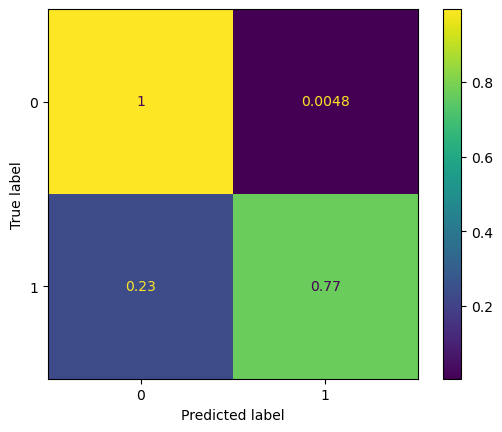

In [33]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_preds, normalize = 'true')

# 8. Feature importance 

**[8.1]** Print the features importance of tree_best

In [34]:
tree_best.feature_importances_

array([9.37743028e-02, 5.59266667e-02, 5.40620838e-02, 2.58529368e-02,
       4.10447513e-02, 9.00285753e-02, 1.01382033e-01, 2.72851624e-01,
       9.84246361e-02, 5.58468668e-02, 9.09273622e-02, 1.69901924e-03,
       4.31789669e-03, 0.00000000e+00, 1.71387526e-03, 2.25606132e-03,
       1.68987876e-03, 8.96925429e-04, 0.00000000e+00, 9.85621071e-05,
       1.11263386e-03, 1.31083369e-03, 6.54988528e-04, 1.32832464e-03,
       0.00000000e+00, 3.05328319e-04, 2.05457261e-03, 4.00715025e-04,
       3.85456928e-05])

**[8.2]** Create a Dataframe with these values

In [35]:
feat_imp_tree_df = pd.DataFrame(
    {
        'feature': X_data.columns,
     'feature_importance': tree_best.feature_importances_
     }
)

**[8.3]** Sort the previous dataframe and reset its index

In [36]:
feat_imp_tree_df = feat_imp_tree_df.sort_values('feature_importance', ascending=False).reset_index(drop=True)

**[8.4]** We can visualise this information on a graph

In [37]:
alt.Chart(feat_imp_tree_df).mark_bar().encode(
    x='feature_importance',
    y=alt.Y("feature", sort='-x'),
    tooltip=['feature','feature_importance'])

alt.Chart(...)